In [1]:
import warnings
import pickle
warnings.filterwarnings(action='ignore')

# Influenza Type Classifer

In [2]:
import pandas as pd
df1=pd.read_csv("../input/flureports/lab flu confirmed 2008-2013.csv")
df2 =pd.read_csv("../input/flureports/lab flu confirmed 2014 - 2019.csv")

df1= df1.iloc[:, 0:6]
df1.head()

,Week Ending (Friday),State,Age group,Sex,Indigenous status,Type/Subtype
0,03/01/2014,NSW,35-39,Female,not available,A(H3N2)
1,03/01/2014,NSW,80-84,Female,not available,A(unsubtyped)
2,03/01/2014,NSW,80-84,Male,not available,A(unsubtyped)
3,03/01/2014,NSW,85+,Female,not available,A(H3N2)
4,03/01/2014,NT,00-04,Male,non-Indigenous,B


In [3]:
df2= df2.iloc[:, 0:6]
df2.head()

,Week Ending (Friday),State,Age group,Sex,Indigenous status,Type/Subtype
0,03/01/2020,NSW,00-04,Female,not available,A(H1N1)pdm09
1,03/01/2020,NSW,00-04,Female,not available,A(unsubtyped)
2,03/01/2020,NSW,00-04,Female,not available,A(unsubtyped)
3,03/01/2020,NSW,00-04,Male,not available,A(unsubtyped)
4,03/01/2020,NSW,00-04,Male,not available,A(unsubtyped)


In [4]:
#put the two df's together
df = pd.concat([df2, df1], axis=0)
df.head()
print(len(df))

1049869


In [5]:
# create labels
flu_types= df['Type/Subtype'].unique()
print(flu_types)

['A(H1N1)pdm09' 'A(unsubtyped)' 'B' 'A(H3N2)' 'A and B' 'Untyped' 'C'
 'A(H1N1)']


In [6]:
risk = ['pandemic_H1', 'pandemic_unknown', 'seasonal', 'pandemic_H3', 'seasonal_mixed', 'unknown', 'low_risk', 'pre-pandemic']

In [7]:
#create dictionary
risk_dict= dict(zip(flu_types, risk))
print(risk_dict)

{'A(H1N1)pdm09': 'pandemic_H1', 'A(unsubtyped)': 'pandemic_unknown', 'B': 'seasonal', 'A(H3N2)': 'pandemic_H3', 'A and B': 'seasonal_mixed', 'Untyped': 'unknown', 'C': 'low_risk', 'A(H1N1)': 'pre-pandemic'}


In [8]:
#replace class column with classification
df['Class'] = df['Type/Subtype']
df.head()
flu=df.replace({"Class": risk_dict})
flu.head()

,Week Ending (Friday),State,Age group,Sex,Indigenous status,Type/Subtype,Class
0,03/01/2020,NSW,00-04,Female,not available,A(H1N1)pdm09,pandemic_H1
1,03/01/2020,NSW,00-04,Female,not available,A(unsubtyped),pandemic_unknown
2,03/01/2020,NSW,00-04,Female,not available,A(unsubtyped),pandemic_unknown
3,03/01/2020,NSW,00-04,Male,not available,A(unsubtyped),pandemic_unknown
4,03/01/2020,NSW,00-04,Male,not available,A(unsubtyped),pandemic_unknown


In [9]:
flu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1049869 entries, 0 to 178631
Data columns (total 7 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   Week Ending (Friday)  1049869 non-null  object
 1   State                 1049869 non-null  object
 2   Age  group            1049869 non-null  object
 3   Sex                   1049869 non-null  object
 4   Indigenous status     1049869 non-null  object
 5   Type/Subtype          1049869 non-null  object
 6   Class                 1049869 non-null  object
dtypes: object(7)
memory usage: 64.1+ MB


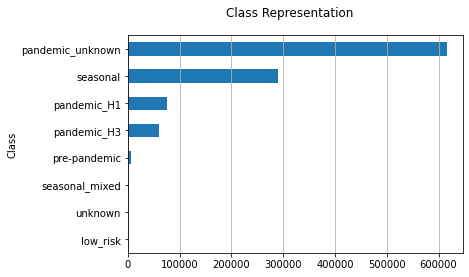

In [10]:
# Label frequency
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.suptitle("Class Representation", fontsize=12)
flu["Class"].reset_index().groupby("Class").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

# Pre-processing for Text Classification

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize and fit CountVectorizer with given text documents
vectorizer = CountVectorizer(analyzer='char').fit(flu['Type/Subtype'])

# use the vectorizer to transform the document into word count vectors (Sparse)
word_mat = vectorizer.transform(flu['Type/Subtype'])

In [12]:
from sklearn.preprocessing import LabelEncoder
# creating instance of labelencoder
labelencoderF = LabelEncoder()
# using the encoder to encode the categorical columns
y = labelencoderF.fit_transform(flu['Class'])

## Split Data

In [13]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(word_mat, y, test_size=0.3)

# Modeling
### Training

In [14]:
# Model Training
from sklearn.naive_bayes import MultinomialNB

from sklearn.linear_model import LogisticRegression
# instantiate the model as clf(classifier) and train it
clf = MultinomialNB()
clf.fit(x_train, y_train)

mod = LogisticRegression()
mod.fit(x_train, y_train)


LogisticRegression()

## Prediction / Evaluation

In [15]:
#make class predictions
pred = clf.predict(x_test)
#transform labels back to text
preds = labelencoderF.inverse_transform(pred)
preds

#make class predictions
predm = mod.predict(x_test)
#transform labels back to text
predsm = labelencoderF.inverse_transform(predm)
predsm

array(['pandemic_unknown', 'seasonal', 'pandemic_H3', ...,
       'pandemic_unknown', 'seasonal', 'seasonal'], dtype=object)

In [16]:
#Transform test target back to text
yt= labelencoderF.inverse_transform(y_test)
yt
ytm= labelencoderF.inverse_transform(y_test)
yt

array(['pandemic_unknown', 'seasonal', 'pandemic_H3', ...,
       'pandemic_unknown', 'seasonal', 'seasonal'], dtype=object)

In [17]:
# confusiong matrix
# Creating  a confusion matrix,which compares the y_test and y_pred
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(yt, preds)

cm2 = confusion_matrix(ytm, predsm)


In [18]:
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['pandemic_H1', 'pandemic_unknown', 'seasonal', 'pandemic_H3', 'seasonal_mixed', 'unknown', 'low_risk', 'pre-pandemic'], 
                     columns = ['pandemic_H1', 'pandemic_unknown', 'seasonal', 'pandemic_H3', 'seasonal_mixed', 'unknown', 'low_risk', 'pre-pandemic'])


cm_df2 = pd.DataFrame(cm2,
                     index = ['pandemic_H1', 'pandemic_unknown', 'seasonal', 'pandemic_H3', 'seasonal_mixed', 'unknown', 'low_risk', 'pre-pandemic'], 
                     columns = ['pandemic_H1', 'pandemic_unknown', 'seasonal', 'pandemic_H3', 'seasonal_mixed', 'unknown', 'low_risk', 'pre-pandemic'])

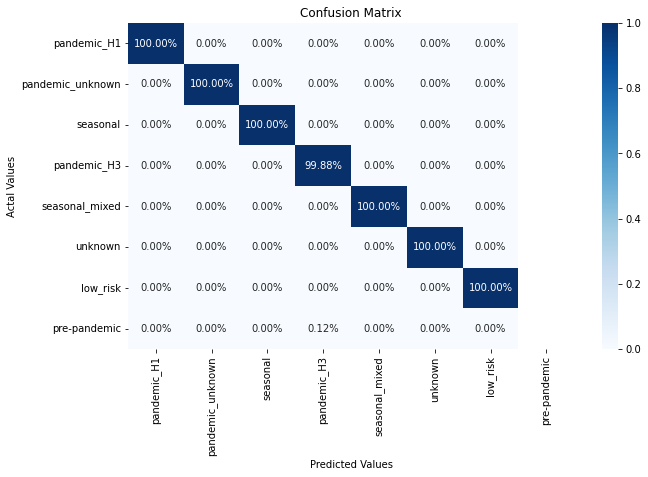

In [19]:
import seaborn as sns
import numpy as np
#Plotting the confusion matrix of Multinomial Bayes
plt.figure(figsize=(10,6))
sns.heatmap(cm_df/np.sum(cm_df), annot=True, cmap='Blues', fmt='.2%')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

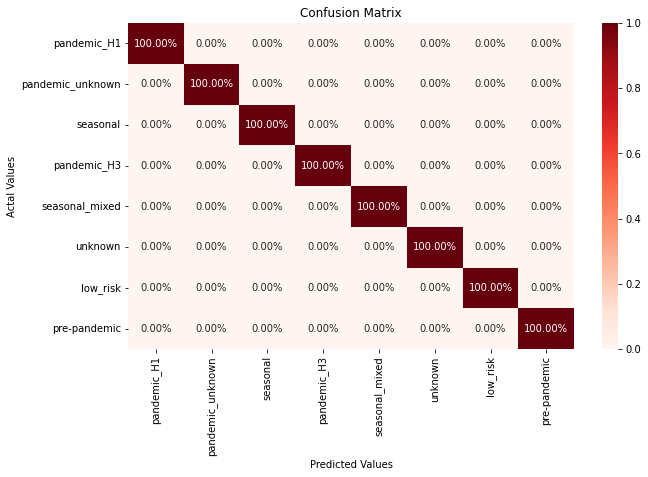

In [20]:
import seaborn as sns
import numpy as np
#Plotting the confusion matrix of Logistic Regesssor
plt.figure(figsize=(10,6))
sns.heatmap(cm_df2/np.sum(cm_df2), annot=True, cmap='Reds', fmt='.2%')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [21]:
#serialise logistic regressor
filename = 'flu_class.sav'
pickle. dump(mod, open(filename, 'wb'))

# Epidemic Predictor

In [22]:
#load data
#df2=pd.read_csv("../input/flureports/FluNetInteractiveReport.csv")
#df2.head(1)
data=pd.read_csv("../input/flureports/WPOFluNetInteractiveReport.csv", parse_dates=['EDATE'], index_col='EDATE', skiprows=3)
data.tail(1)

,Country,WHOREGION,FLUREGION,Year,Week,SDATE,SPEC_RECEIVED_NB,SPEC_PROCESSED_NB,AH1,AH1N12009,...,AH5,ANOTSUBTYPED,INF_A,BYAMAGATA,BVICTORIA,BNOTDETERMINED,INF_B,ALL_INF,ALL_INF2,TITLE
EDATE,,,,,,,,,,,,,,,,,,,,,
2022-03-27,Viet Nam,Western Pacific Region of WHO,South-East Asia,2022,12,2022-03-21,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,Sporadic


## EDA

In [23]:
nan_values= data.isna()
nan_columns = nan_values.any()
#columns_with_nan = df.columns[nan_columns].tolist()
print(nan_columns)

Country              False
WHOREGION            False
FLUREGION            False
Year                 False
Week                 False
SDATE                False
SPEC_RECEIVED_NB      True
SPEC_PROCESSED_NB     True
AH1                   True
AH1N12009             True
AH3                   True
AH5                   True
ANOTSUBTYPED          True
INF_A                 True
BYAMAGATA             True
BVICTORIA             True
BNOTDETERMINED        True
INF_B                 True
ALL_INF               True
ALL_INF2              True
TITLE                False
dtype: bool


In [24]:
data.dtypes

Country               object
WHOREGION             object
FLUREGION             object
Year                   int64
Week                   int64
SDATE                 object
SPEC_RECEIVED_NB     float64
SPEC_PROCESSED_NB    float64
AH1                  float64
AH1N12009            float64
AH3                  float64
AH5                  float64
ANOTSUBTYPED         float64
INF_A                float64
BYAMAGATA            float64
BVICTORIA            float64
BNOTDETERMINED       float64
INF_B                float64
ALL_INF              float64
ALL_INF2             float64
TITLE                 object
dtype: object

In [25]:
data = data.fillna(0) #fill any remaining gaps with 0
_=data.pop('SPEC_RECEIVED_NB') #remove the number of specimen received
_=data.pop('SPEC_PROCESSED_NB') #remove the number of specimen processed
data['SDATE'] = pd.to_datetime(data['SDATE']) #from object to datetime
data.head()

,Country,WHOREGION,FLUREGION,Year,Week,SDATE,AH1,AH1N12009,AH3,AH5,ANOTSUBTYPED,INF_A,BYAMAGATA,BVICTORIA,BNOTDETERMINED,INF_B,ALL_INF,ALL_INF2,TITLE
EDATE,,,,,,,,,,,,,,,,,,,
2000-01-09,Australia,Western Pacific Region of WHO,Oceania Melanesia Polynesia,2000,1,2000-01-03,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Sporadic
2000-01-16,Australia,Western Pacific Region of WHO,Oceania Melanesia Polynesia,2000,2,2000-01-10,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Sporadic
2000-01-23,Australia,Western Pacific Region of WHO,Oceania Melanesia Polynesia,2000,3,2000-01-17,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,Sporadic
2000-01-30,Australia,Western Pacific Region of WHO,Oceania Melanesia Polynesia,2000,4,2000-01-24,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,No Activity
2000-02-06,Australia,Western Pacific Region of WHO,Oceania Melanesia Polynesia,2000,5,2000-01-31,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Sporadic


In [26]:
# data = data.fillna(0)
# nan_values= data.isna()
# nan_columns = nan_values.any()
# #columns_with_nan = df.columns[nan_columns].tolist()
# print(nan_columns)

In [27]:
target=data.pop('TITLE')
one_hot_encoded_data = pd.get_dummies(data)
one_hot_encoded_data.tail()

,Year,Week,SDATE,AH1,AH1N12009,AH3,AH5,ANOTSUBTYPED,INF_A,BYAMAGATA,...,Country_New Zealand,Country_Papua New Guinea,Country_Philippines,Country_Republic of Korea,Country_Singapore,Country_Viet Nam,WHOREGION_Western Pacific Region of WHO,FLUREGION_Eastern Asia,FLUREGION_Oceania Melanesia Polynesia,FLUREGION_South-East Asia
EDATE,,,,,,,,,,,,,,,,,,,,,
2022-02-27,2022,8,2022-02-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,1,0,0,1
2022-03-06,2022,9,2022-02-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,1,0,0,1
2022-03-13,2022,10,2022-03-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,1,0,0,1
2022-03-20,2022,11,2022-03-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,1,0,0,1
2022-03-27,2022,12,2022-03-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,1,0,0,1


<AxesSubplot:title={'center':'Influenza trend'}, xlabel='EDATE'>

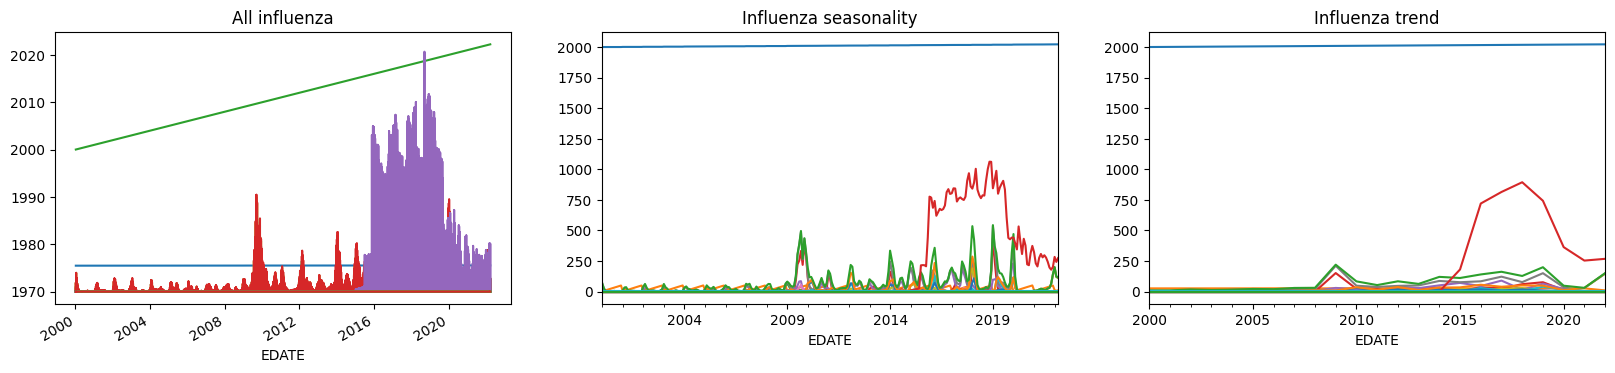

In [28]:
cat_data=one_hot_encoded_data
df_inf=cat_data.resample('1m').mean()
df2_inf=cat_data.resample('1y').mean()
#check for seasonality, trend, 
fig, axes = plt.subplots(1,3, figsize=(20,4), dpi=100)
cat_data.plot(title='All influenza', legend=False, ax=axes[0])
df_inf.plot(title='Influenza seasonality', legend=False, ax=axes[1])
df2_inf.plot(title='Influenza trend', legend=False, ax=axes[2])
#data['AH5'].pl

In [29]:
#Check if data is non-stationary using ADF
cols= cat_data.columns[3:]
from statsmodels.tsa.stattools import adfuller
print("Observations of Dickey-fuller test")
for col in cols:
    dftest = adfuller(cat_data[col], autolag='AIC')
    #print(f'Results for the predictor values in {col}')
    #print("Test statistic = {:.3f}".format(dftest[0]))
    #print("P-value = {:.3f}".format(dftest[1]))
    #print("Critical values :")
    for k, v in dftest[4].items():
        if v<dftest[0]:
            print(f'The {col} data in not stationary with {100-int(k[:-1])}% confidence')
        #print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

    #dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
    #for key,value in dftest[4].items():
     #   dfoutput['critical value (%s)'%key]= value
    #print(dfoutput)


Observations of Dickey-fuller test
The Country_Cambodia data in not stationary with 99% confidence
The Country_Cambodia data in not stationary with 95% confidence
The Country_China data in not stationary with 99% confidence
The Country_China data in not stationary with 95% confidence
The Country_Fiji data in not stationary with 99% confidence
The Country_Fiji data in not stationary with 95% confidence
The Country_Japan data in not stationary with 99% confidence
The Country_Japan data in not stationary with 95% confidence
The Country_Lao People's Democratic Republic data in not stationary with 99% confidence
The Country_Lao People's Democratic Republic data in not stationary with 95% confidence
The Country_Malaysia data in not stationary with 99% confidence
The Country_Malaysia data in not stationary with 95% confidence
The Country_Mongolia data in not stationary with 99% confidence
The Country_Mongolia data in not stationary with 95% confidence
The Country_New Caledonia data in not sta

### Except for the one-hot encoded data, the rest of the relevant features are stationary

## Transfrom text target to numerical

## Time series prediction with prophet

In [30]:
#!sudo pip install fbprophet

In [31]:
# check prophet version
import fbprophet
# print version number
print('Prophet %s' % fbprophet.__version__)

Prophet 0.7.1


In [32]:
from pandas import read_csv
from pandas import to_datetime
from fbprophet import Prophet

# load data
#path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'
#prophet_df = read_csv('../input/flureports/WPOFluNetInteractiveReport.csv', skiprows=3)
prophet_df=cat_data.reset_index()
prophet_df.rename(columns = {'EDATE':'ds', 'ALL_INF':'y'}, inplace = True)


# prepare expected column names
df= prophet_df[['ds', 'y']]

#df= [ds, y]
df.columns = ['ds', 'y']
df['ds']= to_datetime(df['ds'])

#split data
from sklearn.model_selection import train_test_split

x_train, x_test= train_test_split(df, test_size=0.3)
x_train.sort_values(by='ds', axis=0, ascending=True, inplace=True)
x_test.sort_values(by='ds', axis=0, ascending=True, inplace=True)
# define the model
model = Prophet()
# fit the model
model.fit(x_train)

Initial log joint probability = -42.7095


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       30825.3    0.00348518       312.364      0.8456      0.8456      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       30830.7   0.000172776       311.245           1           1      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       30832.5   0.000555282       540.049           1           1      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     383       30833.2   1.92248e-05       122.413     6.6e-08       0.001      518  LS failed, Hessian reset 
     399       30833.5   0.000737564        148.86           1           1      539   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     465       30833.7   6.50519e-07       79.0968     0.04436      0.5866      6

In [33]:
future= model.make_future_dataframe(periods=14)
forecast=model.predict(future)

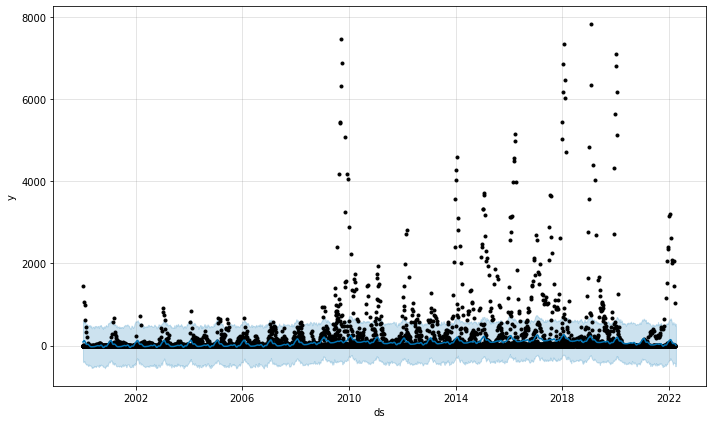

In [34]:
fig1 =model.plot(forecast)

In [35]:
regs=['Year', 'Week', 'SDATE', 'AH1', 'AH1N12009', 'AH3', 'AH5',
       'ANOTSUBTYPED', 'INF_A', 'BYAMAGATA', 'BVICTORIA', 'BNOTDETERMINED',
       'INF_B', 'ALL_INF2', 'Country_Australia', 'Country_Cambodia',
       'Country_China', 'Country_Fiji', 'Country_Japan',
       "Country_Lao People's Democratic Republic", 'Country_Malaysia',
       'Country_Mongolia', 'Country_New Caledonia', 'Country_New Zealand',
       'Country_Papua New Guinea', 'Country_Philippines',
       'Country_Republic of Korea', 'Country_Singapore', 'Country_Viet Nam',
       'WHOREGION_Western Pacific Region of WHO', 'FLUREGION_Eastern Asia',
       'FLUREGION_Oceania Melanesia Polynesia', 'FLUREGION_South-East Asia']

In [36]:
prophet_df.head(1)

,ds,Year,Week,SDATE,AH1,AH1N12009,AH3,AH5,ANOTSUBTYPED,INF_A,...,Country_New Zealand,Country_Papua New Guinea,Country_Philippines,Country_Republic of Korea,Country_Singapore,Country_Viet Nam,WHOREGION_Western Pacific Region of WHO,FLUREGION_Eastern Asia,FLUREGION_Oceania Melanesia Polynesia,FLUREGION_South-East Asia
0,2000-01-09,2000,1,2000-01-03,0.0,0.0,1.0,0.0,0.0,1.0,...,0,0,0,0,0,0,1,0,1,0


In [37]:
#split data
from sklearn.model_selection import train_test_split

x_train, x_test= train_test_split(prophet_df, test_size=0.3)
x_train.sort_values(by='ds', axis=0, ascending=True, inplace=True)
x_test.sort_values(by='ds', axis=0, ascending=True, inplace=True)
#Additional Regressor
pro_regressor= Prophet()
for r in regs:
    pro_regressor.add_regressor(r)
#Fitting the data
pro_regressor.fit(x_train)
#serialise prophet regressor
filename = 'prophet.sav'
pickle. dump(pro_regressor, open(filename, 'wb'))

Initial log joint probability = -16.6582
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        114541   1.97731e-05   4.40014e+06      0.3718      0.3718      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        114614   4.52409e-06        423072           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        114634   1.61156e-06        414096           1           1      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        114642   9.11714e-07        613663      0.4514      0.4514      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        114665   2.22633e-05   1.79205e+06      0.7027      0.7027      556   
    Iter      log prob        ||dx||      ||grad||       alpha  

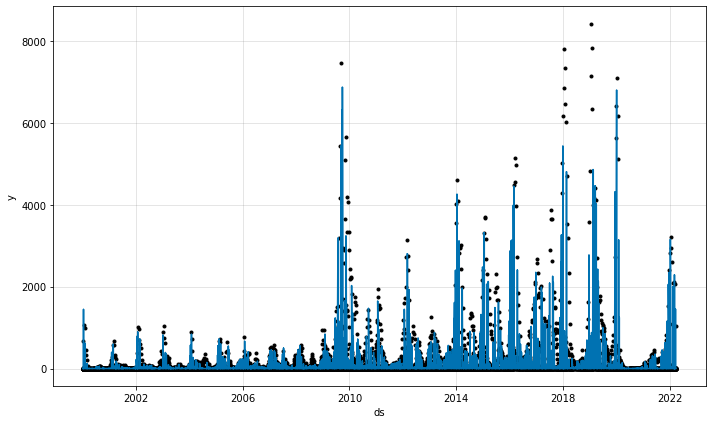

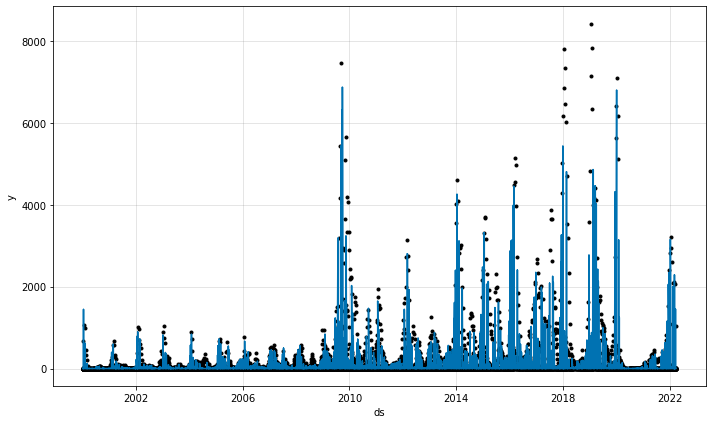

In [38]:
future_data = pro_regressor.make_future_dataframe(periods=14)
#forecast the data for Test  data
forecast_data = pro_regressor.predict(x_test)
pro_regressor.plot(forecast_data)

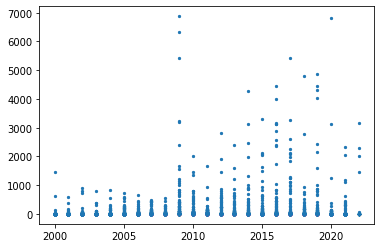

In [39]:
plt.scatter(x=x_test.Year, y=x_test.y, s=5)

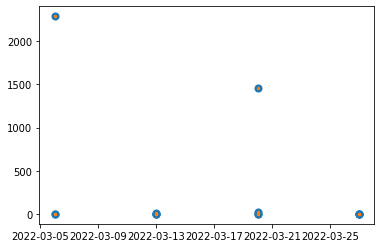

In [40]:
#compare 14day forecast with test data
x=x_test.iloc[-15:,:]
plt.scatter(x=x.ds, y=x.y, s=50)
forecast=forecast_data.iloc[-15:,:]
plt.scatter(x=forecast.ds, y=forecast.yhat, s=5)

In [41]:
import os
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from scipy import stats
import seaborn as sns

In [42]:
%%time
#Lookup layer layer for week
week = data.Week
weeks = list(week.unique())
week_size = len(weeks) + 1
week_lookup_layer = layers.IntegerLookup(max_tokens=week_size)
week_lookup_layer.adapt(pd.DataFrame({"weeks":weeks}))

2022-05-01 18:44:58.146854: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-05-01 18:44:58.256351: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


CPU times: user 173 ms, sys: 21.2 ms, total: 194 ms
Wall time: 314 ms


In [43]:
data.columns

Index(['Country', 'WHOREGION', 'FLUREGION', 'Year', 'Week', 'SDATE', 'AH1',
       'AH1N12009', 'AH3', 'AH5', 'ANOTSUBTYPED', 'INF_A', 'BYAMAGATA',
       'BVICTORIA', 'BNOTDETERMINED', 'INF_B', 'ALL_INF', 'ALL_INF2'],
      dtype='object')

# Epidemic Classifier 
> Now that can predict future trends, we need to know if we are predicting an epidemic or not. We build a classification model for that

In [44]:
cat_data.dtypes

Year                                                 int64
Week                                                 int64
SDATE                                       datetime64[ns]
AH1                                                float64
AH1N12009                                          float64
AH3                                                float64
AH5                                                float64
ANOTSUBTYPED                                       float64
INF_A                                              float64
BYAMAGATA                                          float64
BVICTORIA                                          float64
BNOTDETERMINED                                     float64
INF_B                                              float64
ALL_INF                                            float64
ALL_INF2                                           float64
Country_Australia                                    uint8
Country_Cambodia                                     uin

### Transform categorical columns

In [45]:
## Label encode the text
from sklearn.preprocessing import LabelEncoder
# creating instance of labelencoder
labelencoder = LabelEncoder()#one hot encode the categores from label encoder
# using the encoder to encode the categorical columns
Y= labelencoder.fit_transform(target)
Y
#y=y.reshape(-1, 1) 


array([4, 4, 4, ..., 4, 4, 4])

In [46]:
data2=cat_data
_=data2.pop('SDATE')
data2.head(1)

,Year,Week,AH1,AH1N12009,AH3,AH5,ANOTSUBTYPED,INF_A,BYAMAGATA,BVICTORIA,...,Country_New Zealand,Country_Papua New Guinea,Country_Philippines,Country_Republic of Korea,Country_Singapore,Country_Viet Nam,WHOREGION_Western Pacific Region of WHO,FLUREGION_Eastern Asia,FLUREGION_Oceania Melanesia Polynesia,FLUREGION_South-East Asia
EDATE,,,,,,,,,,,,,,,,,,,,,
2000-01-09,2000,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,1,0,1,0


In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(data2.iloc[:,3:], Y, test_size=0.3)

In [48]:
# Model Training

from sklearn.linear_model import LogisticRegression
# instantiate the model as clf(classifier) and train it

outbreak= LogisticRegression()
outbreak.fit(X_train.ALL_INF.array.reshape(-1, 1), Y_train)

#serialise outbreak regressor
filename = 'outbreak.sav'
pickle. dump(outbreak, open(filename, 'wb'))

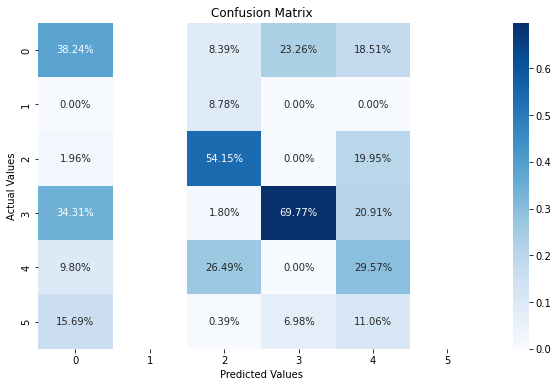

In [49]:
pred=outbreak.predict(X_test.ALL_INF.array.reshape(-1, 1))
# confusiong matrix

# Creating  a confusion matrix,which compares the y_test and y_pred
from sklearn.metrics import confusion_matrix
cmr = confusion_matrix(Y_test, pred)


# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_dfr = pd.DataFrame(cmr)

import seaborn as sns
import numpy as np
#Plotting the confusion matrix
plt.figure(figsize=(10,6))
sns.heatmap(cm_dfr/np.sum(cm_dfr), annot=True, cmap='Blues', fmt='.2%')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

## Classifying the outbreak category of our forecasted data
> Now that we have a model that classifies outbreaks, we run it on the forecasts from prophet to classify them

In [50]:
preds = outbreak.predict(forecast_data.yhat.array.reshape(-1, 1))
y2=labelencoder.inverse_transform(preds)
y2

array(['No Report', 'No Report', 'No Report', ..., 'No Report',
       'No Report', 'No Report'], dtype=object)

### Let's check how the outbreak classes of the prophet forecat compares against the test data by plotting a confusion matrix

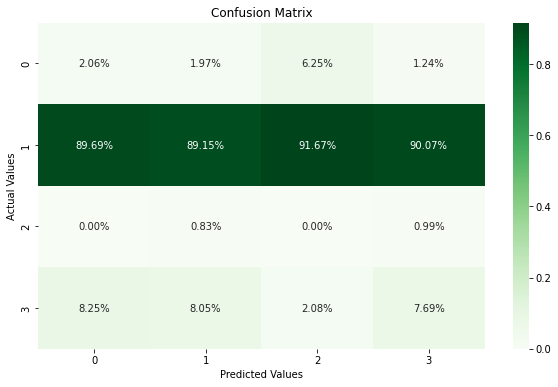

In [51]:
from sklearn.metrics import confusion_matrix
mr = confusion_matrix(pred, preds)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_dr = pd.DataFrame(mr)
import seaborn as sns
import numpy as np
#Plotting the confusion matrix
plt.figure(figsize=(10,6))
sns.heatmap(cm_dr/np.sum(cm_dr), annot=True, cmap='Greens', fmt='.2%')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [52]:
#cat_data=cat_data.reset_index()
#cat_data_=cat_data.pop('EDATE')

In [53]:
flus=cat_data.iloc[:,2:12]
#flus=flus.reset_index()
flus.head()
#ndf = pd.DataFrame(flus.values / cat_data.ALL_INF.values, columns=flus.columns)
#ndf = ndf.assign(Total=ndf.sum(1)).fillna(0)


,AH1,AH1N12009,AH3,AH5,ANOTSUBTYPED,INF_A,BYAMAGATA,BVICTORIA,BNOTDETERMINED,INF_B
EDATE,,,,,,,,,,
2000-01-09,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2000-01-16,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2000-01-23,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0
2000-01-30,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2000-02-06,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [54]:

# for f in flus.index:
#         if cat_data['ALL_INF'][f] !=0:
#             d=cat_data['ALL_INF'][f]
#             #print(flus.loc[f])
#             flus.loc[f] = flus.loc[f] > 0.7
# #
# flus['type'] = flus.INF_A == True

In [55]:
#flus.head()

In [56]:
#flus["type"]=flus.apply(lambda x: np.where(x, x.name, 0)) #maps trues to values
#flus['type']=flus.type.apply(lambda x: np.where(x, 'pandemic', 0)) 

In [57]:
#flus.head

In [58]:
# from sklearn.feature_extraction.text import CountVectorizer

# # Initialize and fit CountVectorizer with given text documents
# vectorizer = CountVectorizer(analyzer='char').fit(flu['Type/Subtype'])

# # use the vectorizer to transform the document into word count vectors (Sparse)
# words = vectorizer.transform(trial)

In [59]:
# ps=mod.predict(words)

# #transform labels back to text
# preS= labelencoderF.inverse_transform(ps)
# # preS

In [60]:
# from sklearn.metrics import confusion_matrix
# mrS = confusion_matrix(words, ps)
# # Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
# cmS = pd.DataFrame(mrS)
# import seaborn as sns
# import numpy as np
# #Plotting the confusion matrix
# plt.figure(figsize=(10,6))
# sns.heatmap(cmS/np.sum(cmS), annot=True, cmap='Greens', fmt='.2%')
# plt.title('Confusion Matrix')
# plt.ylabel('Actual Values')
# plt.xlabel('Predicted Values')
# plt.show()

#make class predictions
predm = mod.predict(x_test)### Resources/ References
* Data: [Australian Government](https://www1.health.gov.au/internet/main/publishing.nsf/Content/ohp-pub-datasets.htm)